# Tweets dos possíveis candidatos a presidência em 2022
## Neste estudo queremos determinar qual é a relação entre os possíveis candidatos a presidência para 2022 atraves dos seus tweets publicados. Vamos fazer uma análise destes tweets e treinar um modelo que irá predizer a qual candidato determinado texto pertence.

# Bibliotecas Utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import regex as re
from collections import Counter
from operator import itemgetter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Funções Diversas

In [2]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [3]:
def tokenize(texto):
    doc = nlp.tokenizer(texto)
    return [token.lower_ for token in doc if not token.is_punct]

In [4]:
def unnest_tokens(df, # Data Frame (em linhas)
                  coluna_tokenize, # nome da coluna com os textos (tweets)
                  coluna_token_nome='palavra', # nome da coluna com os tokens
                  tokenizer_function=tokenize): # what tokenizer to use
    
    return (df[coluna_tokenize]
              .apply(tokenizer_function)
              .apply(pd.Series)
              .stack()
              .reset_index(level=0)
              .set_index('level_0')
              .rename(columns={0: coluna_token_nome})
              .join(df.drop(coluna_tokenize, 1), how='left')
              .reset_index(drop=True))

In [5]:
def clean_stopwords(df, coluna_token="palavra"):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df = df[~ df[coluna_token].isin(stop_words_portugues | stop_words_ingles | stop_words_espanhol | symbols)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if re.match(r'http*', w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if emoji_pattern.match(w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if (w.startswith('@') | w.startswith('#') | w.startswith('\r')))]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if w == 'rt')]
    return df

# Carregando os dados 

Os dados foram conseguidos via a API.V2 do tweeter diretamente do Banco de Dados do tweeter. Utilizamos a versão 2 desta API que permite um máximo de 3200 tweets por conta. Portanto a nossa análise vai estar limitada a este número máximo de mensagens o que em alguns casos cobre todos os tweets do político e em outras apenas o último ano.

Utilizamos esta API através do site WORKBENCH - https://app.workbenchdata.com/workflows/142512/

In [6]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
cols = ['nome'] + [col for col in df_politicos if col != 'nome']
df_politicos = df_politicos[cols]
df_politicos.reset_index(inplace=True)

In [7]:
df_politicos.head(10)

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   
5      5  Amoedo  2021-04-19T12:19:42Z   
6      6  Amoedo  2021-04-18T19:21:07Z   
7      7  Amoedo  2021-04-18T19:21:06Z   
8      8  Amoedo  2021-04-18T15:42:35Z   
9      9  Amoedo  2021-04-18T15:42:25Z   

                                                text                   id  
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735  
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259  
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825  
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517  
4                     Informações de @OGloboPolitica  1384121090243383296  
5  A CPI da Pandemia no Senado deve investigar o ...  1384119514418216969  
6  Leia a coluna completa em https://t.co/rvNDUpnqgA  1383863178853969921  
7  "Membros do Executivo e do Legislativo não ace...  1383863176891015168  
8                       Informações de @RevistaEpoca  1383808183223734272  
9  O governo federal gastará R$500 mil em uma cam...  1383808141897342986

In [8]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31633 entries, 0 to 31632
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       31633 non-null  int64 
 1   nome        31633 non-null  object
 2   created_at  31633 non-null  object
 3   text        31633 non-null  object
 4   id          31633 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


# WordClouds e outras análises

In [66]:
# stopwords e simbolos a retirar
stop_words_portugues = set(stopwords.words('portuguese'))
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '|', ' ', 'ser', 'vai', 'pra', 'q', 'p', 'tb', 'vou', 'ter'])

In [67]:
nlp = spacy.load("pt_core_news_sm")

In [68]:
# criando dataframe apenas com as palavras e os politicos
df_palavras = unnest_tokens(df_politicos.drop(['index','created_at','id'], axis=1), 'text')

In [69]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905721 entries, 0 to 905720
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  905721 non-null  object
 1   nome     905721 non-null  object
dtypes: object(2)
memory usage: 13.8+ MB


In [70]:
df_palavras = clean_stopwords(df_palavras)

In [71]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473885 entries, 2 to 905720
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  473885 non-null  object
 1   nome     473885 non-null  object
dtypes: object(2)
memory usage: 10.8+ MB


In [72]:
df_palavras.head()

palavra    nome
2  presidente  Amoedo
3   americano  Amoedo
4         joe  Amoedo
5       biden  Amoedo
6     anuncia  Amoedo

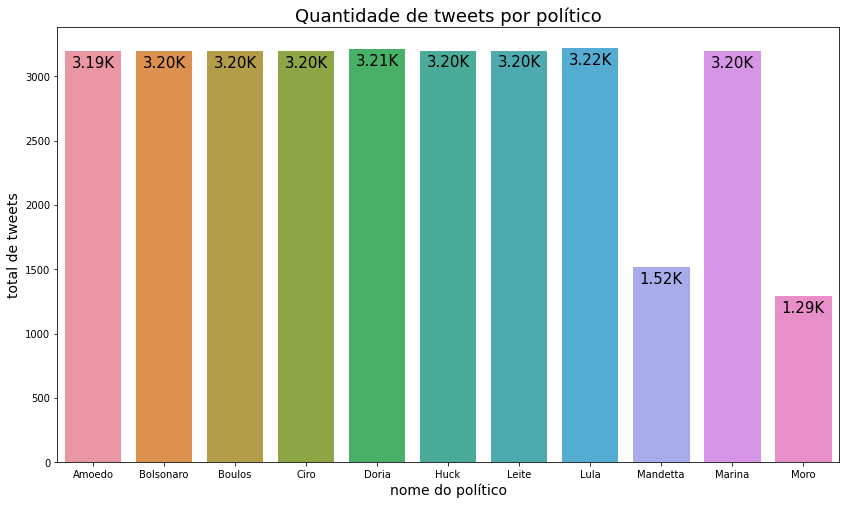

In [73]:
#quantidade de tweets por político

df_plot = df_politicos.groupby('nome').agg(total =('text','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de tweets", size=14)
plt.title("Quantidade de tweets por político", size=18)
for p in splot.patches:
    splot.annotate(format((p.get_height()/1000), '.2f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

### Conforme informamos no começo da análise o número de tweets está limitado em 3200. Verificamos que os candidatos Mandetta e Moro não possuem este número minimo. Buscando nas datas vemos que os dois, mesmo possuindo conta a menos tempo que os outros, publicam menos em um mesmo período.

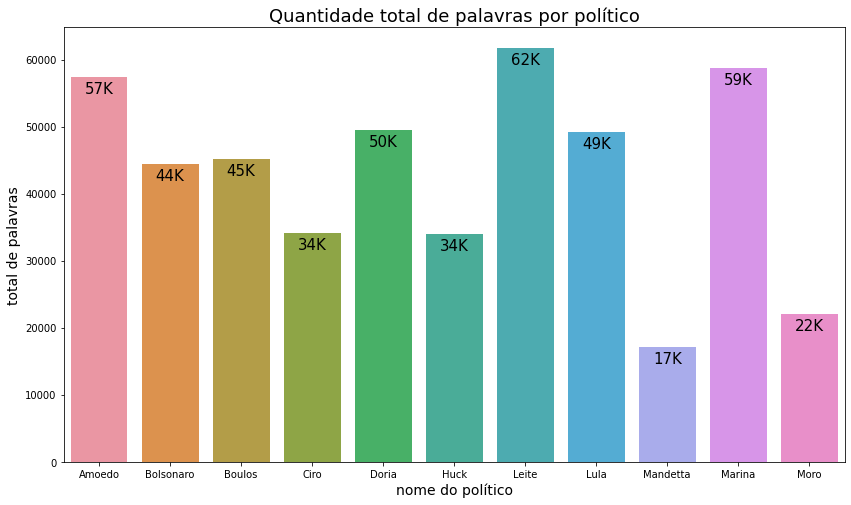

In [74]:
# quantidade de palavras por político

df_plot = df_palavras.groupby('nome').agg(total =('palavra','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de palavras por político", size=18)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()/1000), '.0f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

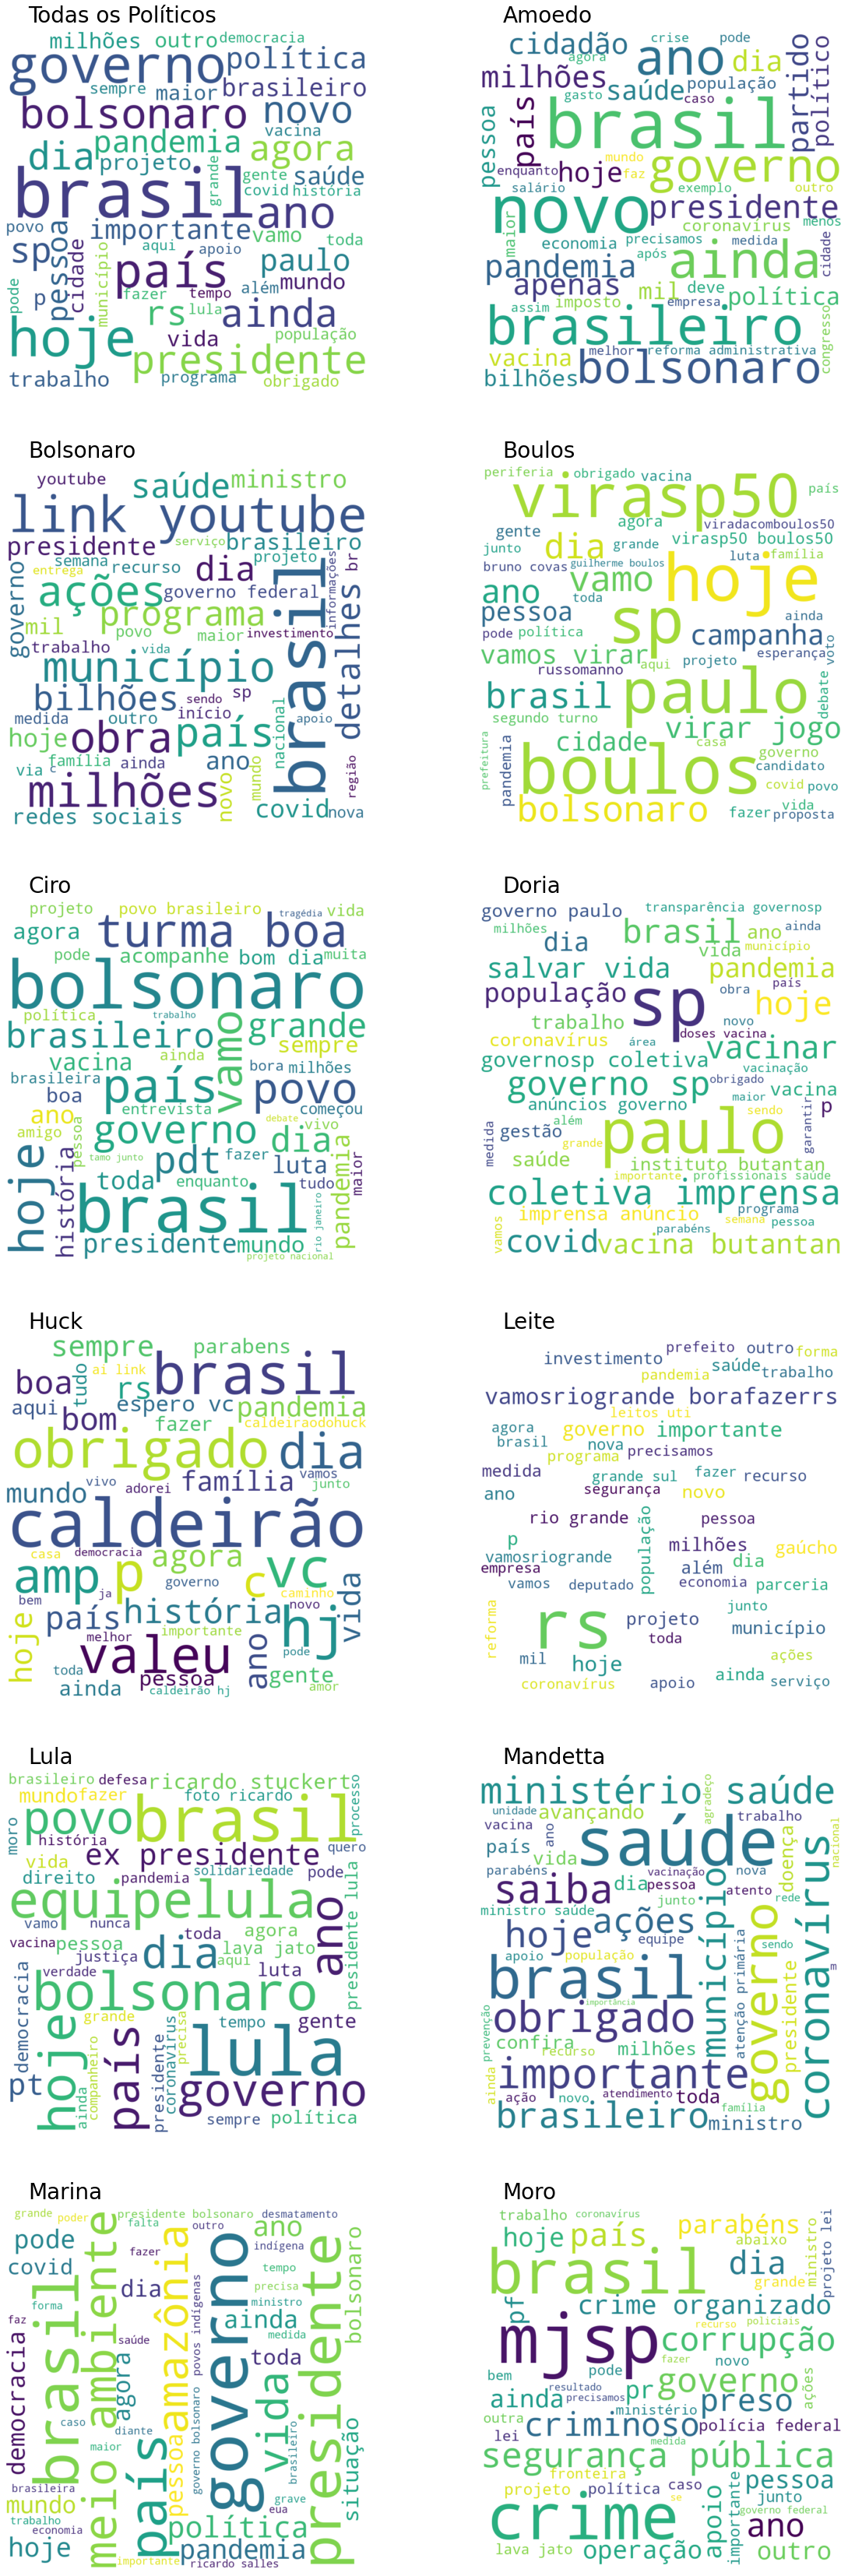

In [75]:
# wordcloud por político
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='w')
xc = 0
yc = 1
sumario = " ".join(s for s in df_palavras['palavra'])
wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, background_color='white').generate(sumario)
ax[0][0].imshow(wordcloud, interpolation="bilinear")
ax[0][0].text(50, -20, 'Todas os Políticos', fontsize=28, color='k')
ax[0][0].axis('off')

for idx in range(11):
    sumario = " ".join(s for s in df_palavras['palavra'][df_palavras['nome'] == nome_politicos[idx]])
    wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, 
            background_color='white').generate(sumario)      
    ax[xc][yc].imshow(wordcloud, interpolation="bilinear")
    ax[xc][yc].text(50, -20, nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

#plt.tight_layout(pad=0) 
plt.show()

# Análise de frequências

In [76]:
# montando dataframe de frequências

c = Counter(df_palavras['palavra']).most_common()
df_palavras_qtd = pd.DataFrame(c, columns=['palavra', 'qtd'])
for politico in nome_politicos:
    c = Counter(df_palavras['palavra'][df_palavras['nome'] == politico]).most_common()
    d = pd.DataFrame(c, columns=['palavra', politico])
    #d[f'f-{politico}'] = d[politico] / df_palavras_qtd['qtd']
    df_palavras_qtd = pd.merge(df_palavras_qtd, d, on='palavra')

In [77]:
#df_palavras_qtd[df_palavras_qtd['palavra'] == " "]
df_palavras_qtd[:50]

palavra   qtd  Amoedo  Bolsonaro  Boulos  Ciro  Doria  Huck  Leite  \
0        brasil  3492     529        406     211   461    248   226    100   
1       governo  2907     292        240     160   213    470    35    284   
2          hoje  2275     142        116     284   237    319   125    423   
3         saúde  2040     212        152     121   149    337    88    227   
4     bolsonaro  2032     276         77     285   618     39     1      6   
5           dia  1696      87        150     172   194    221   222    141   
6          país  1616     226        137      91   190     70   113     54   
7       milhões  1597     221        279      97   108    278    26    303   
8    presidente  1593     233        167      44    97     68    21     83   
9            sp  1447      33         88     371    11    857    20     17   
10     pandemia  1429     235         54     146   103    284   106    165   
11        vamos  1401     114         20     467   306    130    65    105   
12          mil  1364     226        191     132    93    272    37    222   
13        paulo  1304      51         46     366    56    577    27     38   
14         anos  1211     150         90     146    74    119    88    142   
15      pessoas  1197     119         85     180    52    139    72    147   
16  coronavírus  1165     172         46      13    24    309    12    199   
17         vida  1148      98         49      81    79    212    99    103   
18         novo  1141     502         52      58    52     76    48    138   
19        ainda  1069     239         70      73    54     82    81    146   
20        agora  1035     157         55     125   115     52   107    114   
21    população   945     120         59      61    25    286    21    182   
22           rs   933       4         62      11     7      2   103    731   
23         povo   908      11         78      84   257     16    28     41   
24        fazer   893     169         21     157    68     34    93    103   
25       vacina   879     121         51      82    57    397    32     22   
26         pode   863     179         42      86    63     31    68     54   
27  brasileiros   861     136        109      39   126    205    19     10   
28        mundo   853      71         64      66   122     47   101     27   
29     covid-19   834      90        203      22    40    267    21     40   
30     obrigado   790      23         35     104    74    119   237     31   
31       grande   790      44         87      55   109     74    18    200   
32      federal   784     110        156      23    46     41     5     81   
33          ano   777     115         73      56    49     60    37    156   
34        maior   773     115         90      69    77     83    62     87   
35     trabalho   760      65        104      56    54    121    32    115   
36     política   749     122         18      93    56     13    41     77   
37     ministro   736      63         94      22    35     18     8     59   
38    segurança   713      68         65      23     8    100    10    221   
39      projeto   710      82         46      70   114     42    30    102   
40      pública   700      48         36      44    60    108    12    154   
41     nacional   699      38        104      26   122     48    10     61   
42      combate   686      87        149      26    15    129    28     63   
43         meio   665      41         50      48    29     53    38     72   
44        apoio   655      36         64     103    46     76     9    112   
45   importante   646      29         18      26    39     60    52    247   
46      momento   645     108         37      31    34     99    44    110   
47        vidas   640     122         29      34    49    238    20     32   
48        crise   638     168         23      30    50     59    31     71   
49          boa   637      34         49      23   270     55   105     15   

    Lula  Mandetta  Marina  M

In [78]:
df_palavras_freq = df_palavras_qtd.copy()
for politico in nome_politicos:
     df_palavras_freq[politico] =  df_palavras_qtd[politico]/df_palavras_qtd['qtd']

df_palavras_freq

palavra   qtd    Amoedo  Bolsonaro    Boulos      Ciro     Doria  \
0       brasil  3492  0.151489   0.116266  0.060424  0.132016  0.071019   
1      governo  2907  0.100447   0.082559  0.055040  0.073271  0.161679   
2         hoje  2275  0.062418   0.050989  0.124835  0.104176  0.140220   
3        saúde  2040  0.103922   0.074510  0.059314  0.073039  0.165196   
4    bolsonaro  2032  0.135827   0.037894  0.140256  0.304134  0.019193   
..         ...   ...       ...        ...       ...       ...       ...   
934   terceiro    26  0.153846   0.038462  0.038462  0.115385  0.115385   
935     chegam    24  0.083333   0.208333  0.041667  0.041667  0.166667   
936    desejar    22  0.045455   0.045455  0.136364  0.227273  0.090909   
937    pequena    21  0.190476   0.142857  0.095238  0.047619  0.047619   
938  brilhante    19  0.052632   0.052632  0.052632  0.105263  0.368421   

         Huck     Leite      Lula  Mandetta    Marina      Moro  
0    0.064719  0.028637  0.138316  0.056415  0.139748  0.040951  
1    0.012040  0.097695  0.073959  0.052632  0.245958  0.044720  
2    0.054945  0.185934  0.127473  0.030769  0.091429  0.026813  
3    0.043137  0.111275  0.050980  0.218137  0.091176  0.009314  
4    0.000492  0.002953  0.177657  0.008366  0.167323  0.005906  
..        ...       ...       ...       ...       ...       ...  
934  0.115385  0.076923  0.115385  0.115385  0.038462  0.076923  
935  0.083333  0.041667  0.083333  0.083333  0.125000  0.041667  
936  0.090909  0.045455  0.045455  0.136364  0.045455  0.090909  
937  0.047619  0.095238  0.047619  0.095238  0.142857  0.047619  
938  0.052632  0.052632  0.105263  0.052632  0.052632  0.052632  

[939 rows x 13 columns]

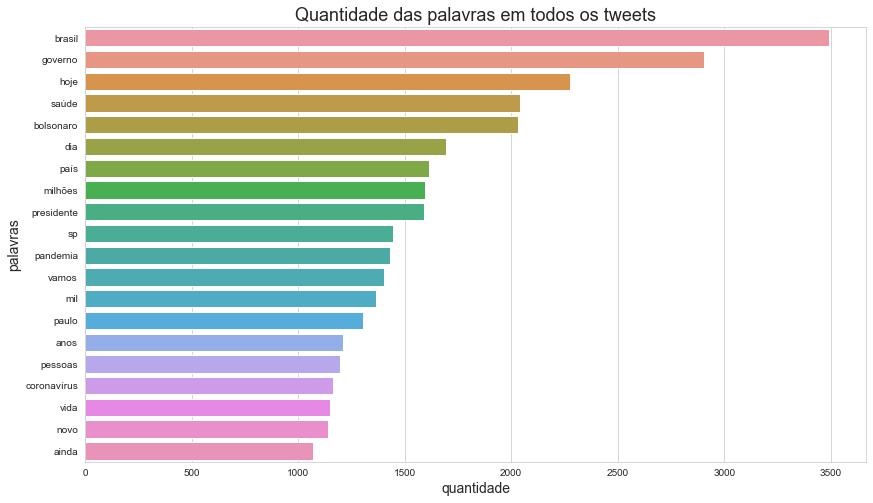

In [84]:
# quantidade de palavras por político
df_plot = df_palavras_freq[:20]

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="qtd", y="palavra", data=df_plot)
sns.set_style("darkgrid")
plt.xlabel("quantidade", size=14)
plt.ylabel("palavras", size=14)
plt.title("Quantidade das palavras em todos os tweets", size=18)

plt.show()

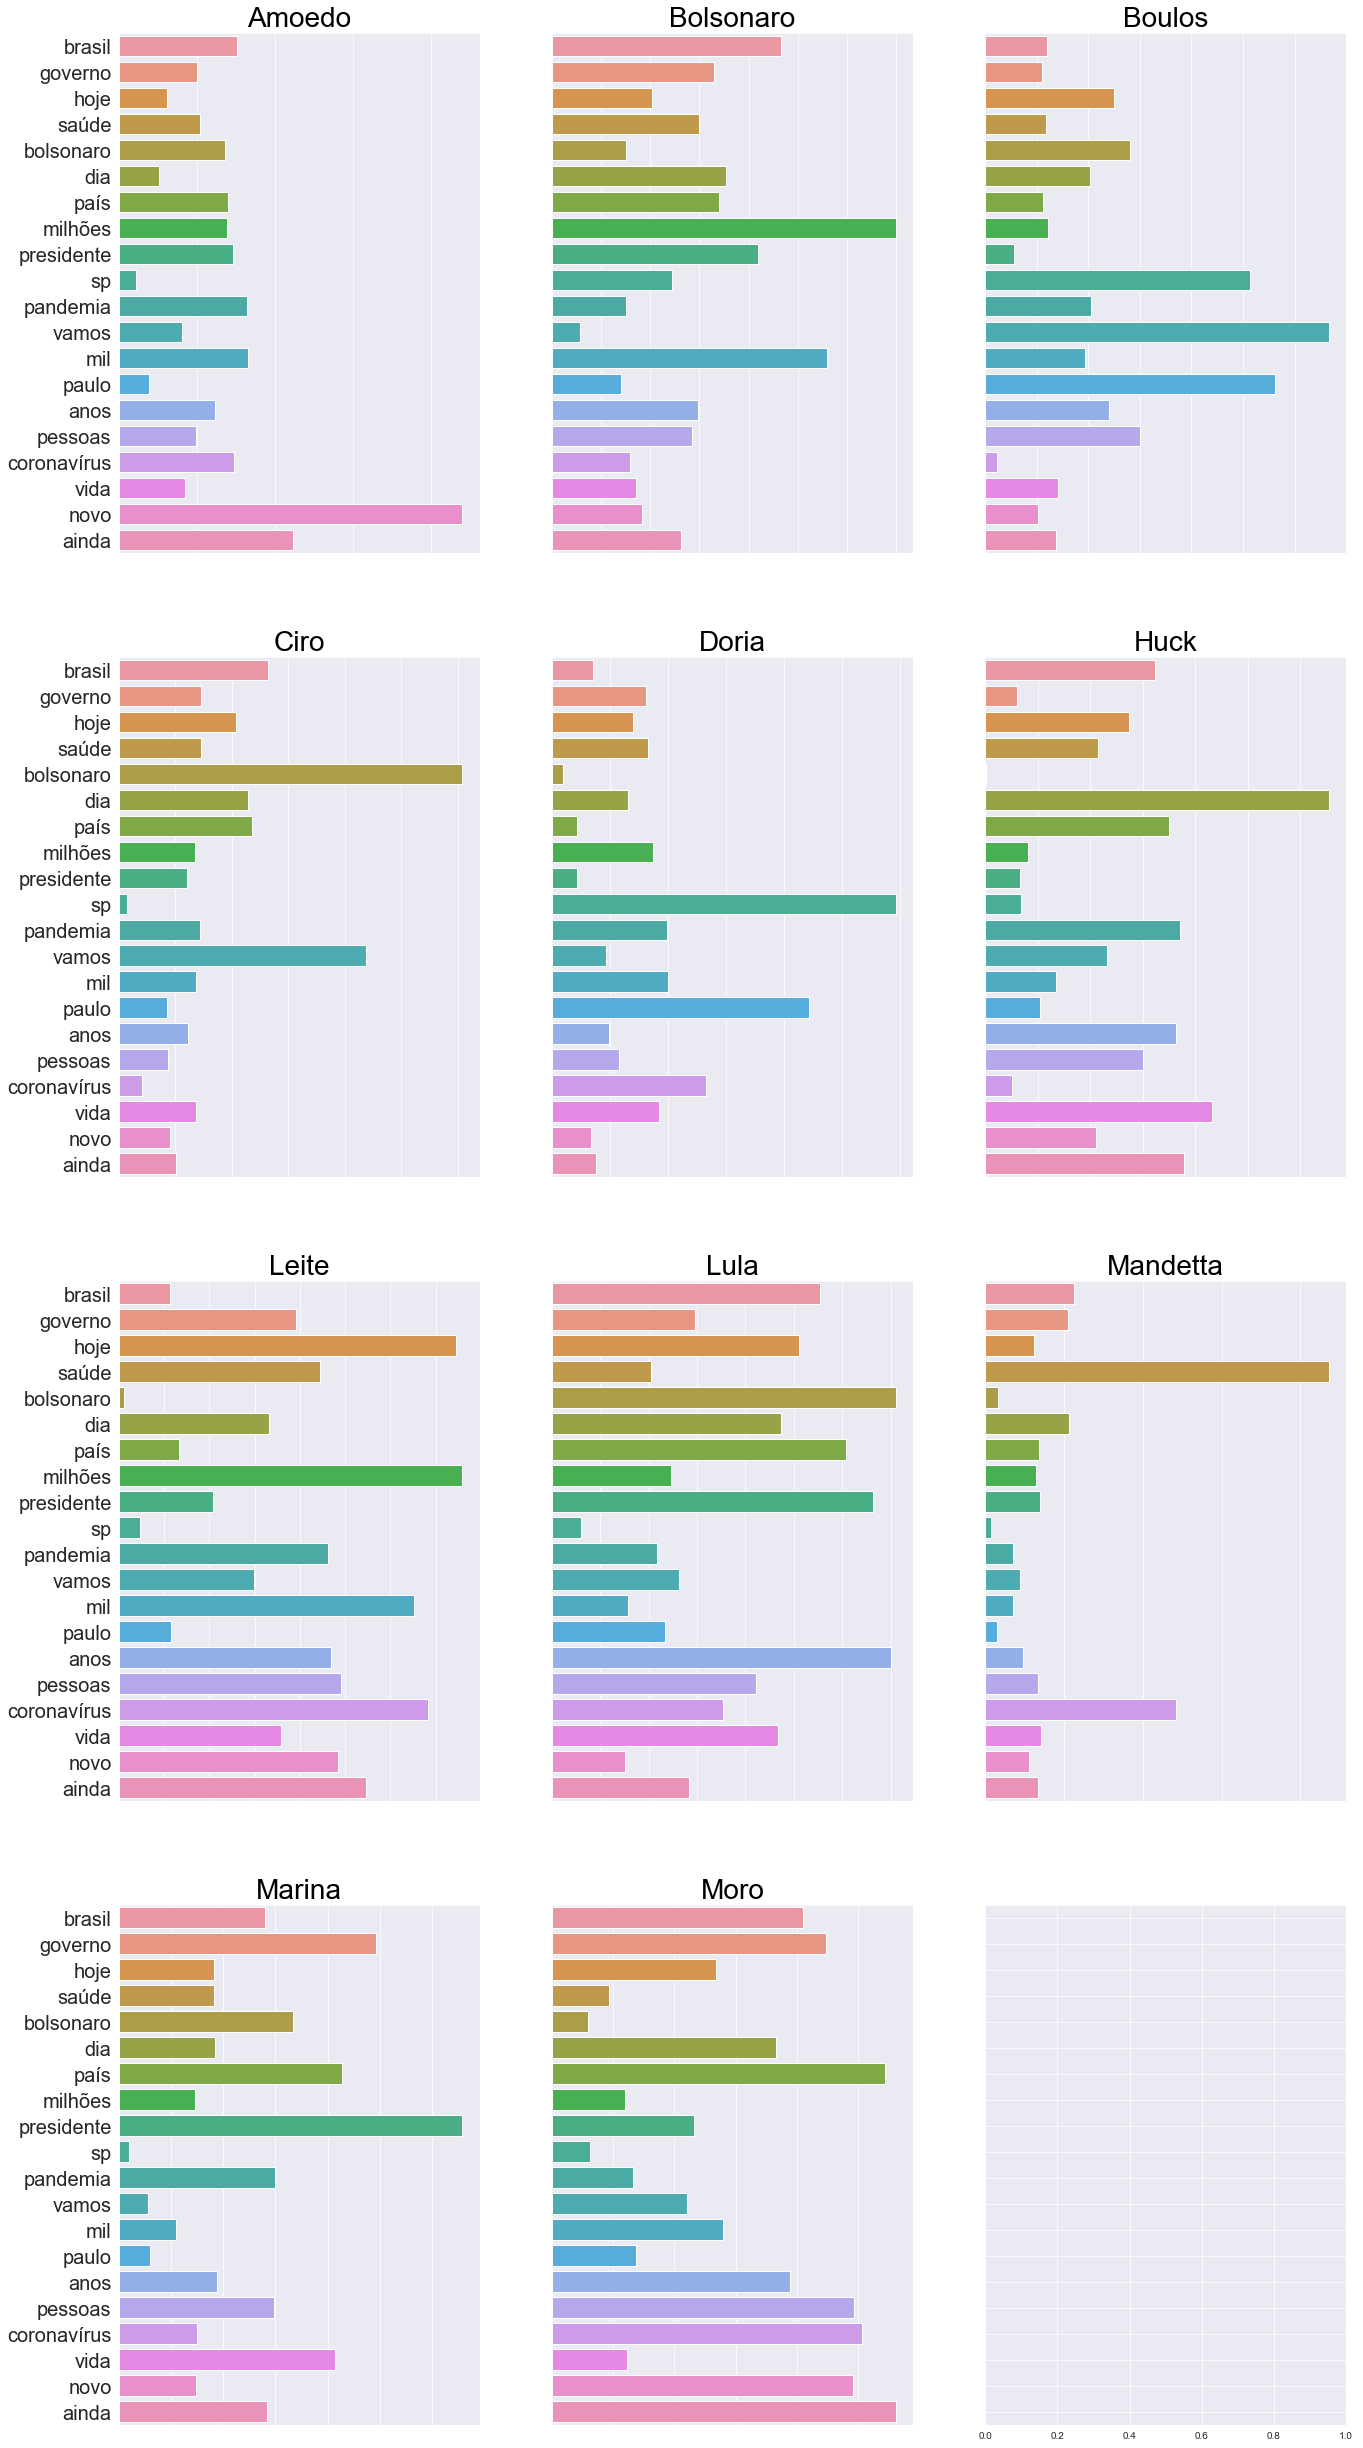

In [101]:
colors = [f'C{x}' for x in range(11)]
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(22, 44), facecolor='w', sharey=True)
xc=0
yc=0
for idx in range(11):
    sns.barplot(y=df_plot['palavra'], x=df_plot[nome_politicos[idx]], ax=ax[xc][yc])
    #ax[xc][yc].barh(y=df_plot['palavra'], width=df_plot[nome_politicos[idx]], height=0.5, color=colors)
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].set_ylabel('')
    ax[xc][yc].set_xlabel('')
    ax[xc][yc].tick_params(axis='y', labelsize=20)
    ax[xc][yc].tick_params(axis='x', labelcolor='white')
    yc += 1
    if (yc == 3):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.show()